In [ ]:
# https://github.com/mrquincle/keras-adversarial-autoencoders/blob/master/Keras%20Adversarial%20Autoencoder%20MNIST.ipynb?fbclid=IwAR3sezckzkLzDkwPzs5hoe41_il8OSFOFDaQJ72nEQOqHbgY369yHihDM3k

In [2]:
"""
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers import Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
"""
####################### Check Mahim #############################################
## https://github.com/eriklindernoren/Keras-GAN/pull/228/files
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate, LSTM, Embedding
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU, UpSampling2D, Conv2D, Lambda
from keras.models import Sequential, Model
from keras.optimizers import Adam
####################### Check Mahim #############################################


from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [ ]:
# python -c 'import tensorflow as tf; print(tf.version)'
import tensorflow as tf
print(tf.version)

In [ ]:
import pickle
pkl_file = open('drive/My Drive/Colab Notebooks/dataset/encoded_text64D_1.pkl', 'rb')
embed_X = pickle.load(pkl_file)
pkl_file = open('drive/My Drive/Colab Notebooks/dataset/encoded_text64D_2.pkl', 'rb')
embed_X2 = pickle.load(pkl_file)
embed_X=np.concatenate((embed_X,embed_X2))
pkl_file = open('drive/My Drive/Colab Notebooks/dataset/encoded_text64D_3.pkl', 'rb')
embed_X2 = pickle.load(pkl_file)
embed_X=np.concatenate((embed_X,embed_X2))
#embed_X=np.reshape(embed_X, (embed_X.shape[0],32,-1))
print(embed_X.shape)
embed_X2=None
"""
pkl_file = open('drive/My Drive/Colab Notebooks/dataset/labels2.pkl', 'rb')
labels = pickle.load(pkl_file)
print(labels.shape)
"""
pkl_file.close()

(91795, 200, 64)


In [3]:
def sample_z(args):
    mu, log_var = args
    batch = K.shape(mu)[0]
    eps = K.random_normal(shape=(batch, latent_dim), mean=0., stddev=1.)
    return mu + K.exp(log_var / 2) * eps

In [4]:
def build_encoder(latent_dim, i_shape):
    deterministic = 0
    vocab=50000
    x = Input(shape=(i_shape[0],))
    x_embed = Embedding(vocab, i_shape[1],
                            input_length=i_shape[0], trainable=False)(x)
    h = LSTM(96,return_sequences=True)(x_embed)
    h = LeakyReLU(alpha=0.2)(h)
    h = h = LSTM(64,return_sequences=True)(h)
    h = LeakyReLU(alpha=0.2)(h)
    if deterministic:
        latent_repr = Dense(latent_dim)(h)
    else:
        mu = Dense(latent_dim)(h)
        log_var = Dense(latent_dim)(h)
        latent_repr = Lambda(sample_z)([mu, log_var])
        latent_repr= Flatten()(latent_repr)
    return Model(x, latent_repr)

In [23]:
def build_discriminator(latent_dim):
    model = Sequential()
    model.add(Dense(2048, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(128))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(Dense(64))
    #model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation="sigmoid"))
    Input(shape=(latent_dim, ))
    return model

In [21]:
def build_decoder(latent_dim, i_shape):
    model = Sequential()
    model.add(Dense(latent_dim, input_dim=latent_dim))
    model.add(Reshape(target_shape=(200,32)))
    model.add(LSTM(64,return_sequences=True))
    model.add(LeakyReLU(alpha=0.2))
    model.add(LSTM(96,return_sequences=True))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(i_shape[1]))
    #z = Input(shape=(latent_dim,))
    #i = model(z)
    return model #Model(z, i)

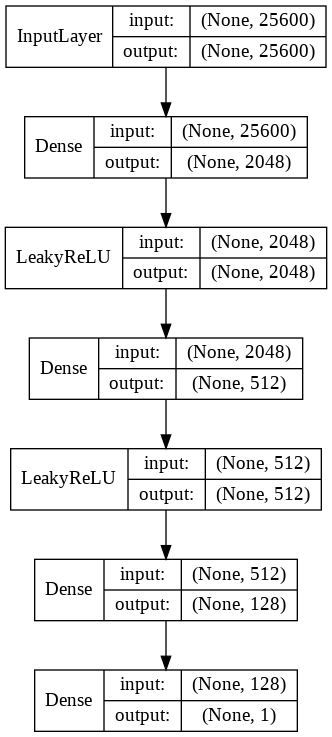

In [24]:
i_shape = (200, 128)
# Results can be found in just_2_rv
#latent_dim = 2
latent_dim = 32

optimizer = Adam(0.0002, 0.5)

######## checking [MAHIM] ###########
#discriminator.trainable = False
######## checking [MAHIM] ###########

# Build and compile the discriminator
discriminator = build_discriminator(i_shape[0]*i_shape[1])
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

plot_model(discriminator, to_file='drive/My Drive/Colab Notebooks/aae_disc_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
print(discriminator.summary())

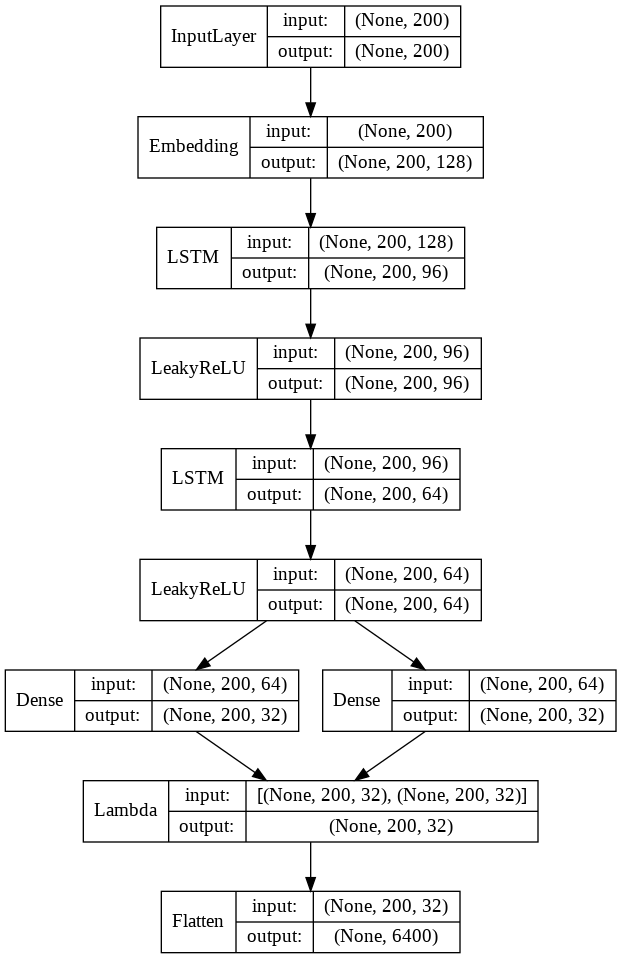

In [8]:
# Build the encoder / decoder
encoder = build_encoder(latent_dim, i_shape)

plot_model(encoder, to_file='drive/My Drive/Colab Notebooks/aae_encoder_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
print(encoder.summary())

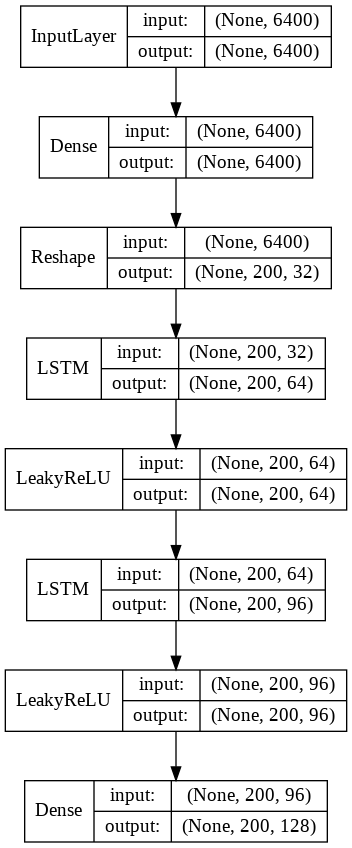

In [22]:
decoder = build_decoder(200*32, i_shape)
plot_model(decoder, to_file='drive/My Drive/Colab Notebooks/aae_decoder_plot.png', show_shapes=True, show_layer_names=False)

In [57]:
print(decoder.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 200, 32)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 200, 64)           24832     
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 200, 64)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 200, 96)           61824     
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 200, 96)           0         
_________________________________________________________________
dense_45 (Dense)             (None, 200, 128)          12416     
Total params: 99,072
Trainable params: 99,072
Non-trainable params: 0
_________________________________________________

In [51]:
# The generator takes the image, encodes it and reconstructs it
# from the encoding
i = Input(shape=i_shape[0])
encoded_repr = encoder(i)
reconstructed_i = decoder(encoded_repr)

# For the adversarial_autoencoder model we will only train the generator
# It will say something like: 
#   UserWarning: Discrepancy between trainable weights and collected trainable weights, 
#   did you set `model.trainable` without calling `model.compile` after ?
# We only set trainable to false for the discriminator when it is part of the autoencoder...
discriminator.trainable = False

# The discriminator determines validity of the encoding
validity = discriminator(encoded_repr)

# The adversarial_autoencoder model  (stacked generator and discriminator)
adversarial_autoencoder = Model(i, [reconstructed_i, validity])
adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'], loss_weights=[0.999, 0.001], optimizer=optimizer)

ValueError: ignored

In [ ]:
print(adversarial_autoencoder.summary())

In [ ]:
epochs=500
batch_size=128
sample_interval=100 

# epochs=10
# batch_size=16
# sample_interval=2 

In [ ]:
# def sample_prior(latent_dim, batch_size):
#     return np.random.normal(size=(batch_size, latent_dim))

########### Check Mahim #################
## Issues of the github link ##
### https://github.com/mrquincle/keras-adversarial-autoencoders/pull/2/files
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
def sample_prior(batch_size, latent_dim):
    return np.random.normal(size=(batch_size, latent_dim))

########### Check Mahim #################

In [ ]:
def sample_images(latent_dim, decoder, epoch):
    r, c = 5, 5

    z = sample_prior(r*c, latent_dim)
    gen_imgs = decoder.predict(z)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [ ]:
for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random batch of images
    idx = np.random.randint(0, embed_X.shape[0], batch_size)
    im = embed_X[idx]

    # latent_fake = self.encoder.predict(imgs)



    latent_fake = encoder.predict(im)
    
    # Here we generate the "TRUE" samples
    # latent_real = sample_prior(latent_dim, batch_size)

    ########### Check Mahim #################
    # latent_real = sample_prior(batch_size, latent_dim)
    latent_real = np.random.normal(size=(batch_size, latent_dim))
    # print(f"shape of latent_real = {latent_real.shape}")
    # print(f"shape of valid = {valid.shape}")

    ########### Check Mahim #################
                      
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(latent_real, valid) ## creating problems
    d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    # Train the generator
    g_loss = adversarial_autoencoder.train_on_batch(im, [im, valid])

    # Plot the progress (every 10th epoch)
    if epoch % 10 == 0:
        print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
    
    # Save generated images (every sample interval, e.g. every 100th epoch)
    #if epoch % sample_interval == 0:
     #   sample_images(latent_dim, decoder, epoch)

In [ ]:

adversarial_autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 200, 64)]    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 6400)         259224400   input_4[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 200, 64)      259230800   model_1[1][0]                    
__________________________________________________________________________________________________
model (Model)                   (None, 1)            14232321    model_1[1][0]                    
Total params: 532,687,521
Trainable params: 518,455,200
Non-trainable params: 14,232,321
___

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
i=keras.Input(shape=i_shape)
intermediate_layer_model = keras.Model(i,
                                       outputs=adversarial_autoencoder.get_layer(index=1).output)


ValueError: ignored

In [ ]:
model = Model([i,p])

In [ ]:
model.predict(embed_X)